# Solving MECP with QAOA+ using "Parameter Fixing" technique

## Import Modules

In [1]:
from utils_to_build_QAOAAnsatz import *

In [2]:
from functools import reduce
import os
import random
import time
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize

## Set Parameters

In [3]:
params = get_parameters_from_user() 

# Get the parameters separately
chosen_instances = params['chosen_instances']
chosen_k = params['chosen_k']
max_p = params['p']
random_attempts = params['random_attempts']
init_string = params['init_string']
n = params['n']

Number of layers (p), default is 3:  
Number of random attempts, default is 20:  
String initialization (all1 or all0), default is 'all1':  
Size n (6, 8, 10), default is 6:  
Number or list of numbers from 1 to 10 for chosen instances, default is [1, ..., 10]:  1,2
Choice for 'chosen_k' (1, 'L=n', 'L=max(L_EC)', 'L=L_MEC'), default is 'L=L_MEC':  


In [5]:
# Define k.
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier  

k_dict = {'L=n': [0.3333333333333333,   0.5,   0.5,   0.3333333333333333,   0.5,   0.5,   0.5,   
                  0.3333333333333333,   0.25,   0.25],
          'L=max(L_EC)': [0.16666666666666666,   0.16666666666666666,   0.25,   0.16666666666666666,  
                          0.3333333333333333, 0.25,   0.25,   0.16666666666666666,   0.08333333333333333,  
                          0.08333333333333333],
          'L=L_MEC': [0.16666666666666666,   0.16666666666666666,   0.16666666666666666,
                      0.1111111111111111,   0.16666666666666666,   0.16666666666666666,   0.25,   
                      0.16666666666666666,  0.08333333333333333,   0.08333333333333333]}

# Arrotondo per eccesso
k_dict_new = {}
for key,value_list in k_dict.items():
    k_dict_new[key] = [round_up(v, 3) for v in value_list]
k_dict_new

{'L=n': [0.334, 0.5, 0.5, 0.334, 0.5, 0.5, 0.5, 0.334, 0.25, 0.25],
 'L=max(L_EC)': [0.167,
  0.167,
  0.25,
  0.167,
  0.334,
  0.25,
  0.25,
  0.167,
  0.084,
  0.084],
 'L=L_MEC': [0.167,
  0.167,
  0.167,
  0.112,
  0.167,
  0.167,
  0.25,
  0.167,
  0.084,
  0.084]}

## For Every Instance Chosen, Do the Minimization

This section runs the **QAOA+** algorithm to solve the **Minimum Exact Cover Problem (MECP)** for selected instances. The key steps are:

1. **Create Output Folder**: A directory named `parameter_fixing_{current_datetime}` is created to store output files.
2. **Iterate Over Instances**: For each instance:
   - Define the instance, calculate Exact Covers (EC), and Minimum Exact Covers (MEC).
   - Prepare quantum circuits for the problem instance (cost and mixing).
   - Initialize QAOA+ with `init_string`
3. **Initialize QAOA+ angles**: use parameters fixing technique to initialize angles.
4. **Run QAOA+**: Optimize parameters (`beta`, `gamma`) for each layer (`p`), running QAOA+ `random_attempts` times.
5. **Post-Processing and Saving**: The best results of each layer are aggregated, saved in `.csv` and `.txt`  files, and a histogram is plotted.

**************************************************
Instance 1 with h = 0.167



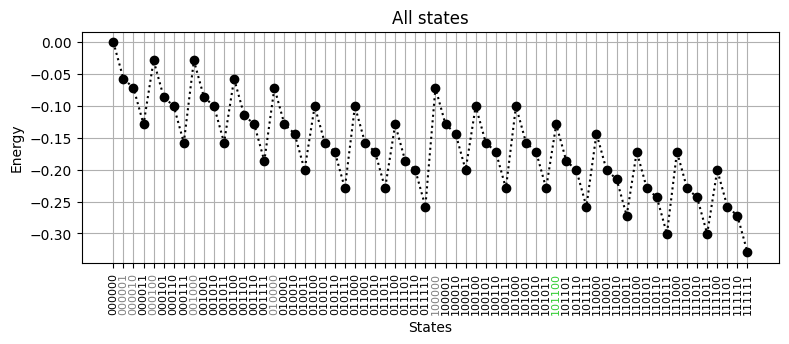

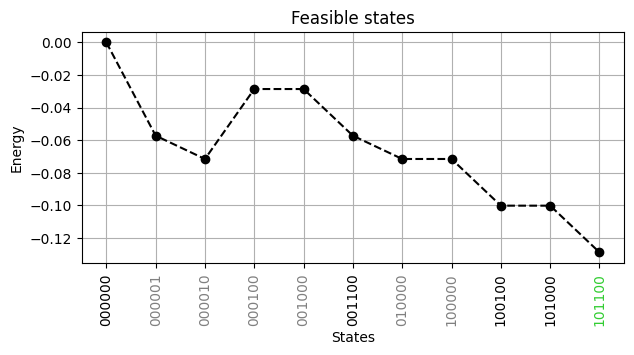


****************** p = 1 ******************
---------- 1/20 random attempts ----------
pars_0 = [4.629238995962893, -6.184418071871197]
bnds = [(0, 6.283185307179586), (-6.46798487503781, 6.46798487503781)]
Optimization terminated successfully.
         Current function value: 0.087755
         Iterations: 48
         Function evaluations: 94
E_min = result.fun + constant = -0.07694531305710774
E_min = result.fun = 0.08775468694289228

Optimal parameters: betas, gammas = [4.556850624176859], [-4.118209745642085e-05]
--> ***UPDATING THE BEST ATTEMPT***

---------- 2/20 random attempts ----------
pars_0 = [3.1408608645884653, -4.831833362604511]
bnds = [(0, 6.283185307179586), (-6.46798487503781, 6.46798487503781)]
Optimization terminated successfully.
         Current function value: 0.087755
         Iterations: 71
         Function evaluations: 133
E_min = result.fun + constant = -0.07694531305710456
E_min = result.fun = 0.08775468694289545

Optimal parameters: betas, gammas = [4.556

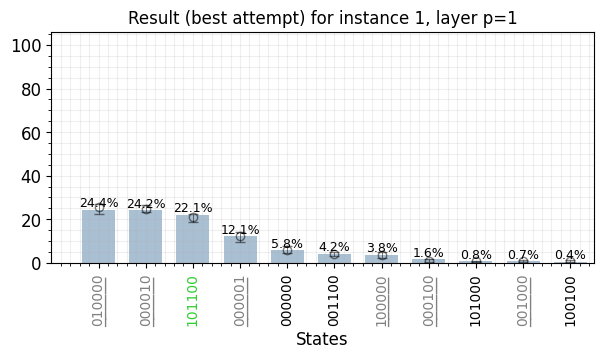


E_best's parameters: betas = [4.55685067593671], gammas = [-8.233294089126553e-06]

Execution time of p=1 layer: 1.2 min

****************** p = 2 ******************
---------- 1/20 random attempts ----------
pars_0 = [4.55685067593671, 5.788964526848536, -8.233294089126553e-06, -5.809439545160536]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781)]
Optimization terminated successfully.
         Current function value: 0.079812
         Iterations: 111
         Function evaluations: 198
E_min = result.fun + constant = -0.08488790477295345
E_min = result.fun = 0.07981209522704656

Optimal parameters: betas, gammas = [5.418425356123727, 5.077554650762546], [-1.0488241973807873e-05, 2.404745888645653e-05]
--> ***UPDATING THE BEST ATTEMPT***

---------- 2/20 random attempts ----------
pars_0 = [4.55685067593671, 3.5663920816532593, -8.233294089126553e-06, -4.022897596731353]
bnds = [(0, 6.283185307179586), (

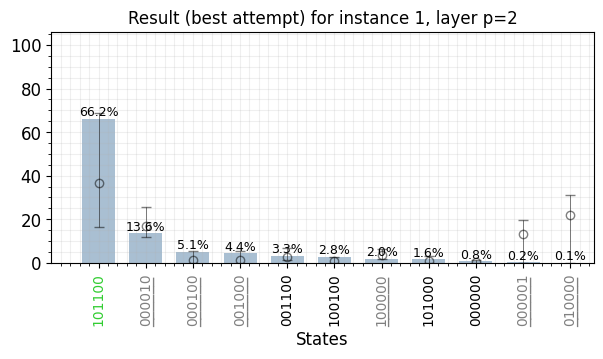


E_best's parameters: betas = [1.223813687616062, 3.2379356515140802], gammas = [-9.151856887507e-06, -3.7129799722396944e-05]

Execution time of p=2 layer: 4.6 min

****************** p = 3 ******************
---------- 1/20 random attempts ----------
pars_0 = [1.223813687616062, 3.2379356515140802, 4.738939404259972, -9.151856887507e-06, -3.7129799722396944e-05, 0.20281151722704038]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781)]
Optimization terminated successfully.
         Current function value: 0.059015
         Iterations: 121
         Function evaluations: 211
E_min = result.fun + constant = -0.1056853090782146
E_min = result.fun = 0.059014690921785413

Optimal parameters: betas, gammas = [1.2238178738609888, 3.2379160006008707, 6.283185307179586], [-9.39046212966474e-06, -3.3721556045202786e-05, 0.24045895476016568]
--> ***UPDATI

/tmp/ipykernel_309/3202799509.py:128: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations


E_min = result.fun + constant = -0.07819372770041583
E_min = result.fun = 0.08650627229958419

Optimal parameters: betas, gammas = [1.752499715413288, 1.8650343538550835, 3.8553012349500886], [2.5520569302842624, 6.467956805845205, 6.452617963576614]
--> ***NOT UPDATING THE BEST ATTEMPT***

---------- 7/20 random attempts ----------
pars_0 = [1.223813687616062, 3.2379356515140802, 0.1719346526948707, -9.151856887507e-06, -3.7129799722396944e-05, -3.72586781152498]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781), (-6.46798487503781, 6.46798487503781)]
Optimization terminated successfully.
         Current function value: 0.057745
         Iterations: 156
         Function evaluations: 272
E_min = result.fun + constant = -0.10695504769759126
E_min = result.fun = 0.05774495230240875

Optimal parameters: betas, gammas = [1.1775262862106275, 3.12021755112474, 0.334247274419331], [-9.

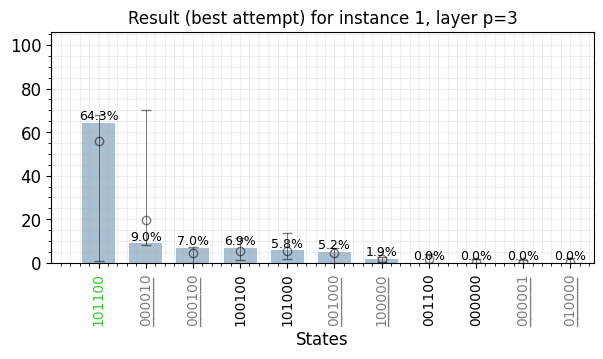


E_best's parameters: betas = [1.1775268513660722, 3.120217446334963, 0.3342440038753933], gammas = [-2.051927055423672e-05, -5.063761705610865e-05, -3.4953825221555466e-05]

Execution time of p=3 layer: 10.3 min

TOTAL ELAPSED TIME: 16.101901880900066 minutes.
**************************************************
Instance 2 with h = 0.167



<Figure size 640x480 with 0 Axes>

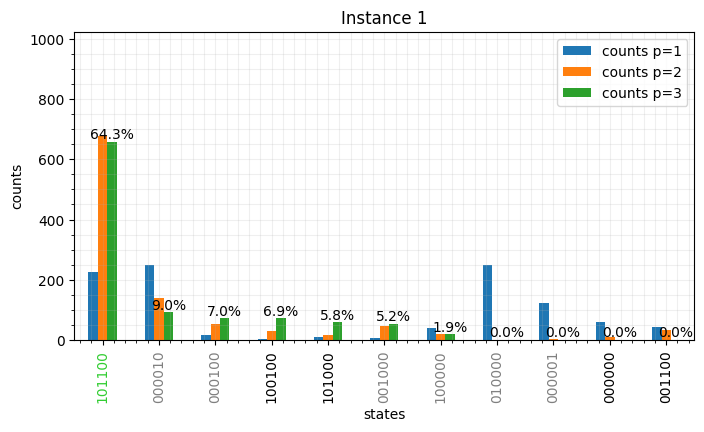

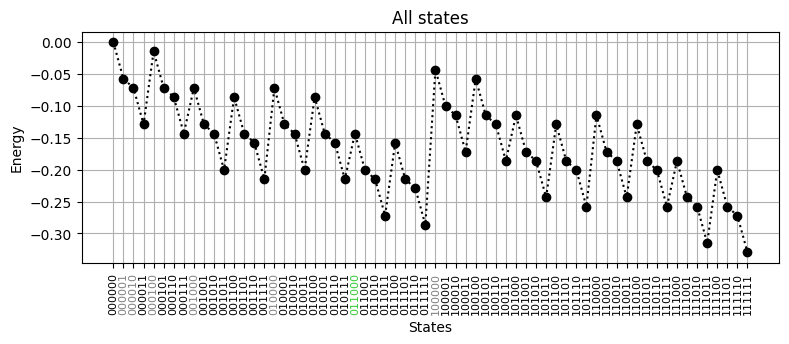

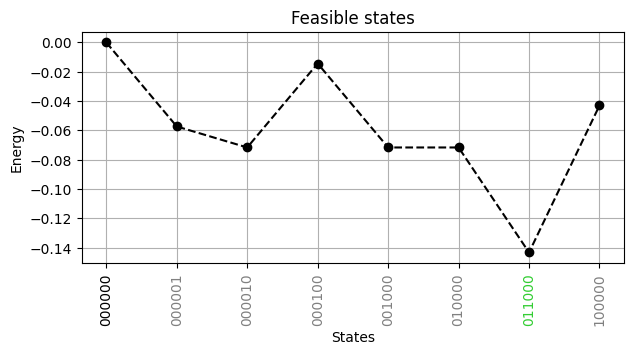


****************** p = 1 ******************
---------- 1/20 random attempts ----------
pars_0 = [4.859989636005237, -9.55207173598817]
bnds = [(0, 6.283185307179586), (-9.995976625058432, 9.995976625058432)]
Optimization terminated successfully.
         Current function value: 0.074467
         Iterations: 48
         Function evaluations: 95
E_min = result.fun + constant = -0.09023319152272173
E_min = result.fun = 0.07446680847727828

Optimal parameters: betas, gammas = [4.122787297113342], [3.8251241666424296e-05]
--> ***UPDATING THE BEST ATTEMPT***

---------- 2/20 random attempts ----------
pars_0 = [5.175382523449331, 5.908391628219761]
bnds = [(0, 6.283185307179586), (-9.995976625058432, 9.995976625058432)]
Optimization terminated successfully.
         Current function value: 0.074467
         Iterations: 54
         Function evaluations: 104
E_min = result.fun + constant = -0.09023319152271726
E_min = result.fun = 0.07446680847728275

Optimal parameters: betas, gammas = [4.12

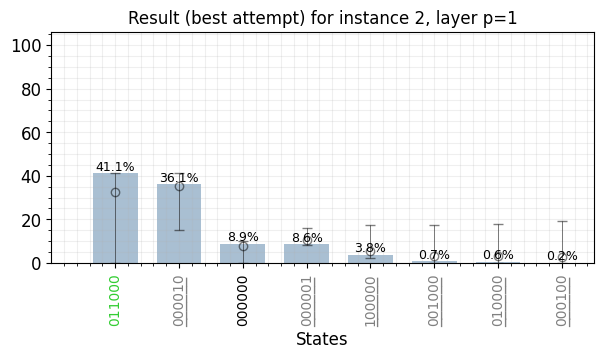


E_best's parameters: betas = [4.12278810162577], gammas = [2.7491341203305123e-05]

Execution time of p=1 layer: 1.6 min

****************** p = 2 ******************
---------- 1/20 random attempts ----------
pars_0 = [4.12278810162577, 0.4488605329993237, 2.7491341203305123e-05, 5.709096552427994]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]
Optimization terminated successfully.
         Current function value: 0.062405
         Iterations: 109
         Function evaluations: 193
E_min = result.fun + constant = -0.10229461606175574
E_min = result.fun = 0.06240538393824427

Optimal parameters: betas, gammas = [3.5148478539714523, 0.707002334718837], [5.0609875547058665e-05, 1.907870140704792e-05]
--> ***UPDATING THE BEST ATTEMPT***

---------- 2/20 random attempts ----------
pars_0 = [4.12278810162577, 0.9690573216442829, 2.7491341203305123e-05, 3.213698579293652]
bnds = [(0, 6.283185307179586)

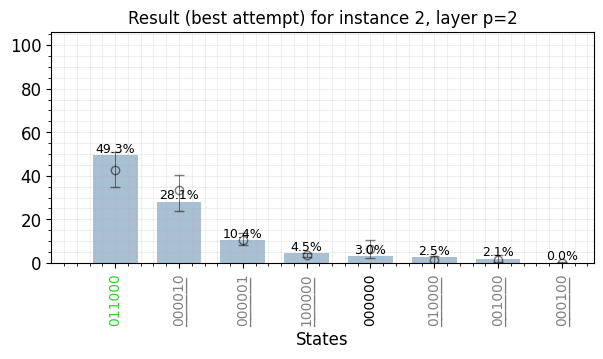


E_best's parameters: betas = [3.5148511689496633, 0.7069992621466962], gammas = [7.661004330110024e-05, -2.256806867900382e-05]

Execution time of p=2 layer: 5.1 min

****************** p = 3 ******************
---------- 1/20 random attempts ----------
pars_0 = [3.5148511689496633, 0.7069992621466962, 3.602891870545903, 7.661004330110024e-05, -2.256806867900382e-05, 0.9525097278759223]
bnds = [(0, 6.283185307179586), (0, 6.283185307179586), (0, 6.283185307179586), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432), (-9.995976625058432, 9.995976625058432)]
Optimization terminated successfully.
         Current function value: 0.062405
         Iterations: 261
         Function evaluations: 439
E_min = result.fun + constant = -0.10229461606217223
E_min = result.fun = 0.06240538393782778

Optimal parameters: betas, gammas = [3.5148520026671872, 0.7069979180998387, 6.283185307179586], [3.743834978793877e-05, -2.4550012195394197e-05, -0.5746300501459165]
--> 

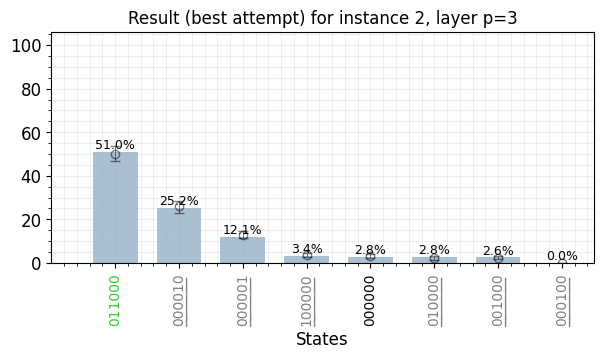


E_best's parameters: betas = [3.517300181923531, 0.6850042403825707, 0.020650241910380056], gammas = [0.0001305259679417654, -2.6543409271015092e-05, 0.0006032533155306013]

Execution time of p=3 layer: 13.5 min

TOTAL ELAPSED TIME: 20.19559509754181 minutes.


<Figure size 640x480 with 0 Axes>

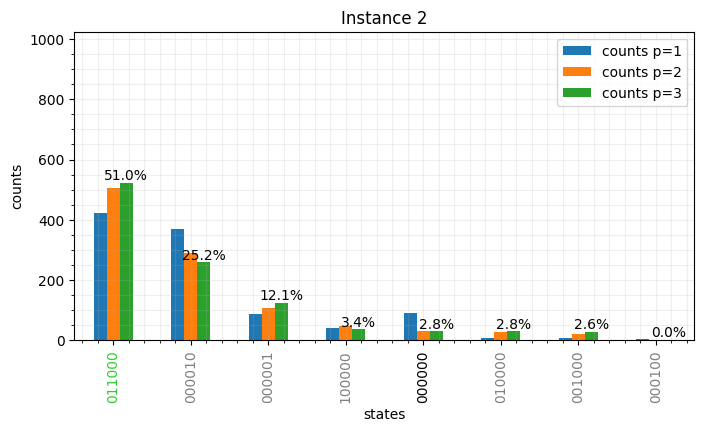

In [7]:
current_datetime = datetime.now().strftime("%Y-%m-%d@%Hh%Mm%Ss")


# Create a  directory where to collect files
folder_path = f"parameter_fixing_{current_datetime}"
os.makedirs(folder_path, exist_ok=True)


# Run QAOA+ for every instance.
for instance in chosen_instances:
    if chosen_k!= 1:
        h = k_dict_new[chosen_k][instance-1]
    else:
        h = 1
    print("*"*50)
    print(f"Instance {instance} with h = {h}\n")

    FILENAME_list = [] # list of .csv containing the final histograms data.
    DATA_FILENAME_list = [] # list of .txt containing metadata such as energies, betas, gammas.

    
    # Define the instance.
    U, subsets_dict = define_instance(n, instance, verbose=False)
    subsets = list(subsets_dict.values())
    _, _, _, _, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]
    
    
    # Plot states vs energy.
    show_spectrum(n, instance, h, fontsize=10)

    
    # Choose the initialization.
    if init_string == 'all1':
        # Only "1"-states.
        init_name = ["".join(elem) for elem in distinct_permutations('0'*(n-1) + '1')]

    elif init_string == 'all0':
        init_name = ["000000"]
        
      
    # Prepare the cost and mixing circuit.
    constant, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, verbose=False)
    qc_mixing = build_mixing_circuit(n, instance, verbose=False)    
    qc_initial, check_counts  = build_initialization_circuit(n, instance, init_name, verbose=False)
    
    # # Check that initialization was correct.
    # plot_histogram(check_counts, ax=plt.subplots()[1], title="Initialization check", color='k')
    # plt.show(block=False) # don't stop execution
    
    
    # Set initial angles.
    gamma_bound = find_gamma_bound(n, instance, h, verbose=False)
    
    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    
    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    

    # Build files' names.
    header = f"dim{n}_mail{instance}_{init_string}" \
           + f"_p{max_p}_{random_attempts}ra_k{h}" \
           + f"_BOUNDS{bnds_string}_pars0{string_0}"

    DATA_FILENAME = os.path.join(folder_path, header + '_data.txt')
    DATA_FILENAME_list.append(DATA_FILENAME)
    
    
    # Collect information in one data-file.
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        DATA_FILE.write(f"current datetime = {current_datetime}")
        DATA_FILE.write(f"The initial state is an equal superposition of: {init_name} \n")
        DATA_FILE.write(f"max_p = {max_p}\n")
        DATA_FILE.write(f"Random attempts for each layer: {random_attempts}\n")

        Energies = []
        list_df_best = []
        TOTAL_start_time = time.time()
    
        # Increase the number of layers step-by-step.
        for p in range(1, max_p+1):
        
            print(f"\n****************** p = {p} ******************")
            pth_start_time = time.time()
            E_best = 100
            Energies_of_layer_p = []
            
            for attempt in range(1,random_attempts+1):
                print(f"---------- {attempt}/{random_attempts} random attempts ----------")
                DATA_FILE.write(f"\n---------- {attempt}/{random_attempts} random attempts ----------\n")
    
                # Build QAOAAnsatz.
                cost_vs_iteration = [] # to save (and plot) iterations
                ansatz = QAOAAnsatz(qc_cost, 
                                    mixer_operator=qc_mixing, 
                                    initial_state=qc_initial, 
                                    reps=p, name='QAOA+')
        
                # Generate a pass manager without providing a backend.
                pm = generate_preset_pass_manager(optimization_level=3)
                ansatz_isa = pm.run(ansatz)
                hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
            
                estimator = StatevectorEstimator()
                sampler = StatevectorSampler()
            
                
                # *************************  FIND OPTIMAL ANGLES  ***************************
                # *************************     THROUGH QAOA+     ***************************
                
                # Set initial angles and angles'bounds.
                if p == 1:
                    pars_0 = [random.uniform(*beta_0)] + [random.uniform(*gamma_0)]  
                else:
                    pars_0 =  pth_betas + [random.uniform(*beta_0)] + pth_gammas + [random.uniform(*gamma_0)]  
                
                bnds = [bnds_beta]*p + [bnds_gamma]*p
                
                print(f"pars_0 = {pars_0}")
                print(f"bnds = {bnds}")
                
                
                # Do the minimization.
                result = minimize(cost_func, # change cost_func -> cost_func_plot to plot iterations
                                  pars_0, bounds=bnds, 
                                  args=(ansatz_isa, hamiltonian_isa, estimator), 
                                  method="Nelder-Mead", 
                                  options={"disp": True, "maxiter": 1200, "maxfev": 1200}, tol=1e-4)
                
                
                # Works only if you chose cost_func_plot.
                if cost_vs_iteration != []:
                    plt.figure()
                    plt.plot(cost_vs_iteration) 
                    plt.xlabel("Iteration")
                    plt.ylabel("Cost")
                    plt.show()
                    
                    
                # Minimum energy reached with minimization.
                E_min = result.fun + constant
                print(f"E_min = result.fun + constant = {E_min}")
                print(f"E_min = result.fun = {result.fun}")
                DATA_FILE.write(f"\nE_min = {E_min}")
                Energies_of_layer_p.append(E_min)
            
            
                # Optimal parameters (betas, gammas) found.
                betas = list(result.x[:p])
                gammas = list(result.x[p:])
                print(f"\nOptimal parameters: betas, gammas = {betas}, {gammas}")
                DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')
        
                
                # Update the best attempt.
                if E_min < E_best:
                    E_best = E_min
#                     d_best = d
                    betas_best = betas
                    gammas_best = gammas
                    best_attempt = attempt
                    print("--> ***UPDATING THE BEST ATTEMPT***\n")
                else:
                    print("--> ***NOT UPDATING THE BEST ATTEMPT***\n")
                    
                    
                # ****************************  RUN THE CIRCUIT  ******************************
                # ************************ WITH OPTIMAL PARAMETERS ****************************

                # Assign to the previously created ansatz the 2p parameters found.
                pars = betas + gammas 
                qc = ansatz.assign_parameters(pars)
                qc.measure_all() # add a measurement

                # Run this circuit.
                qc_isa = pm.run(qc)
                output = sampler.run([qc_isa], shots=1024).result()
                samp_dist = output[0].data.meas.get_counts()
           
                
                # ****************************  POST PROCESS  **********************************
                # *********************** AND SAVE THE OUTPUT HISTOGRAM ************************
            
                # Create a dataframe from the sampling results.
                df = pd.DataFrame(samp_dist.items(), columns=['states', 'counts'])

                # Remove ancillary bits.
                num_ancillas = get_circuit_parameters(subsets, verbose=False)[2]
                df['states'] = df['states'].apply(lambda x: x[num_ancillas:]) 

                # Invert the bit order for the states (e.g., convert "01101" to "10110").
                df['states'] = df['states'].apply(lambda s: str(s)[::-1])  # Invertiamo l'ordine dei bit

                # After removing the ancillary bits, we aggregate counts by state.
                df = df.groupby(['states']).sum().reset_index()

                # Sort in decreasing order.
                df = df.sort_values('counts', ascending=False) 

                # Rename the "counts" column to include attempt details.
                df.columns = ['states', f'counts_p{p}_{attempt}of{random_attempts}']

                # Merge the current attempt dataframe with previously built dataframes.
                if attempt == 1:
                    df_all_attempts = df
                else:
                    df_all_attempts = pd.merge(df_all_attempts, df, on="states", how="outer")    
               
            # *********************************************************************************
    
            Energies.append(Energies_of_layer_p)
            DATA_FILE.write(f"\n----- p = {p} layer -----\nMinimum energy found in each attempt: ")
            DATA_FILE.write(str(Energies_of_layer_p))
            
            print(f"E_best = {E_best}")
            DATA_FILE.write(f"\nE_best = {E_best}")
            
            
            # Plot the best attempt (minimum energy), with error bars
            # representing other attempts in the global dataframe.
            plot_histogram_of_best_column(df_all_attempts, 
                                          f'counts_p{p}_{best_attempt}of{random_attempts}', 
                                          EXACT_COVERS, init_name,
                                          fontsize=12, 
                                          title=f"Result (best attempt) for instance {instance}, layer p={p}")

            # Collect.
            df_best = df_all_attempts[['states', f'counts_p{p}_{best_attempt}of{random_attempts}']]
            df_best.columns = ['states', f'counts_p{p}'] # rename the second column
            list_df_best.append(df_best)
            
            
            # Best parameters'vector of length 2p found for the p-th layer
            pth_betas = betas_best
            pth_gammas = gammas_best
            
            print(f'\nE_best\'s parameters: betas = {pth_betas}, gammas = {pth_gammas}\n')
            print("Execution time of p={0} layer: {1:.1f} min".format(p, (time.time() - pth_start_time)/60))
            DATA_FILE.write(f'\nE_best\'s parameters: betas = {pth_betas}, gammas = {pth_gammas}\n')
            DATA_FILE.write("Execution time of p={0} layer: {1:.1f} min\n".format(p, (time.time() - pth_start_time)/60))


        # Merge DataFrames
        df_final = reduce(lambda left, right: pd.merge(left, right, on='states', how='outer'), list_df_best)
        df_final = df_final.fillna(0) # missing values -> 0
        df_final = df_final.sort_values(by=f'counts_p{max_p}').reset_index(drop=True)

        # Save to csv
        FILENAME = os.path.join(folder_path, header + f".csv")
        df_final.to_csv(FILENAME, index=False)
        
        # ************************ SEE FINAL RESULT ************************
        # Plot all the dataframes in one picture.
        plt.figure()
        plt.rcParams['font.size'] = 10
        df_final = df_final.fillna(0)
        df_final = df_final.sort_values(f'counts_p{max_p}', ascending=False) 
        df_final.plot(x='states', kind="bar", figsize=(8,4), stacked=False)

        # Make labels with percentages (only for the last layer).
        ax1 = plt.gca()
        ax1.set_ylabel("counts")
        to_percentage = lambda x: (x/df_final[f'counts_p{max_p}'].sum())*100
        labels = df_final[f'counts_p{max_p}'].apply(to_percentage).round(1).astype('str') + '%'
        ax1.bar_label(ax1.containers[-1], labels=labels)

        highlight_correct_ticks(plt.gca(), EXACT_COVERS)
        plt.legend(labels=[f'counts p={p}' for p in range (1, max_p+1)])
        plt.minorticks_on()
        plt.grid(alpha=0.2, which='both')
        plt.ylim(0,1024)
        plt.title(f"Instance {instance}")
        
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")

## Read from File


./parameter_fixing_2025-01-30@10h22m24s/dim6_mail1_all1_p3_20ra_k0.167_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781].csv
./parameter_fixing_2025-01-30@10h22m24s/dim6_mail1_all1_p3_20ra_k0.167_BOUNDS[0,2pi]x[-6.46798487503781,6.46798487503781]_pars0[0,2pi]x[-6.46798487503781,6.46798487503781]_data.txt



./parameter_fixing_2025-01-30@10h22m24s/dim6_mail2_all1_p3_20ra_k0.167_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432].csv
./parameter_fixing_2025-01-30@10h22m24s/dim6_mail2_all1_p3_20ra_k0.167_BOUNDS[0,2pi]x[-9.995976625058432,9.995976625058432]_pars0[0,2pi]x[-9.995976625058432,9.995976625058432]_data.txt




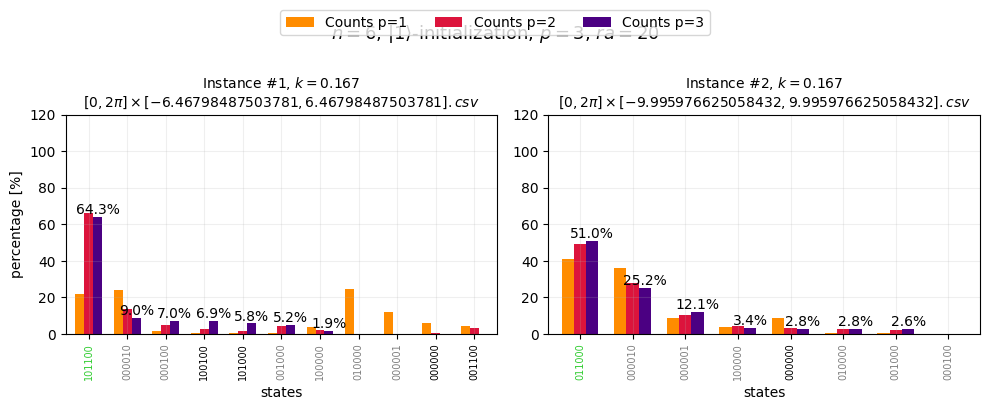

In [9]:
# Uncomment this line to plot data from an existing directory
folder_path = "./parameter_fixing_2025-01-30@10h22m24s/"
files, datafiles = find_files_containing_string(path=folder_path, verbose=True)

l = len(datafiles)
if l > 1:
    # Plot the whole list of files found.
    plot_list_of_files_parameter_fixing(datafiles, files,
                                        dont_show_in_title=["i", "k"], 
                                        dont_show_in_titles=["n", "init", "p", "ra"], 
                                        figsize=(10, l+2), N=10, dpi=100, show_title=True)
else:
    plot_file_parameter_fixing(datafiles[0], files[0],
                               show_title=True,
                               figsize=(8, 4), N=10, dpi=100)